# Transformer-CRF Fusion Models

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from torchcrf import CRF

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [3]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from transformers.tokenization_utils_base import PaddingStrategy
from dataclasses import dataclass

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
# device='cpu'
print(device)

cuda


In [32]:
# Model evaluation
from transformers import EvalPrediction
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [6]:
from prepare_dataset import prepare_data

In [7]:
# training constants
MODEL_NAME = 'bert-base-uncased' # let's try bert first
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10

## Data Loader

In [7]:
# Dataset class for BERT
# class dataset(Dataset):
#     def __init__(self, dataframe, tokenizer, max_len):
#         self.len = len(dataframe)
#         self.data = dataframe
#         self.tokenizer = tokenizer
#         self.max_len = max_len

#     def __getitem__(self, index):
#         sentence = self.data.sentence[index]
#         word_labels = self.data.tags[index]

#         encoding = self.tokenizer(sentence,
#                                   is_split_into_words=True,
#                                   padding='max_length',
#                                   truncation=True,
#                                   max_length=self.max_len)

#         labels = [labels_to_ids[label] for label in word_labels]

#         encoded_labels = np.ones(len(encoding["input_ids"]), dtype=int) * -100
#         label_mask = np.zeros(len(encoding["input_ids"]), dtype=bool)
#         word_ids = encoding.word_ids()

#         previous_word_idx = None
#         for idx, word_idx in enumerate(word_ids):
#             if word_idx is None:
#                 continue
#             elif word_idx != previous_word_idx:
#                 encoded_labels[idx] = labels[word_idx]
#                 label_mask[idx] = True  # mark this token as valid
#                 previous_word_idx = word_idx

#         item = {key: torch.tensor(val) for key, val in encoding.items()}
#         item['labels'] = torch.tensor(encoded_labels)
#         label_mask[0] = True # force it starts with "on"
#         item['label_mask'] = torch.tensor(label_mask)

#         return item

#     def __len__(self):
#         return self.len

In [15]:
# varient for BERT-CRF
class BERTCRFDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df, self.tk, self.max_len = df, tokenizer, max_len

    def __getitem__(self, idx):
        tokens      = self.df.sentence[idx]          # list[str]
        tag_names   = self.df.tags[idx]              # list[str]

        enc = self.tk(
            tokens,
            is_split_into_words=True,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_offsets_mapping=False            # not needed now
        )

        # build label ids; keep –100 on every sub-token and special token
        labels = np.ones(len(enc["input_ids"]), dtype=np.int64) * -100
        for i, word_id in enumerate(enc.word_ids()):
            if word_id is not None and (i == 0 or enc.word_ids()[i-1] != word_id):
                labels[i] = labels_to_ids[tag_names[word_id]]

        item = {k: torch.tensor(v) for k, v in enc.items()}
        item["labels"] = torch.tensor(labels)
        return item

    def __len__(self):
        return len(self.df)

In [9]:
data_dict = prepare_data("../processed_notes.csv")
data = data_dict["data"]
labels_to_ids = data_dict["labels_to_ids"]
ids_to_labels = data_dict["ids_to_labels"]

In [18]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, add_prefix_space=True)
NUM_LABELS = len(labels_to_ids)

In [19]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

# training_set = dataset(train_dataset, tokenizer, MAX_LEN)
# testing_set = dataset(test_dataset, tokenizer, MAX_LEN)
training_set = BERTCRFDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = BERTCRFDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (20305, 4)
TRAIN Dataset: (16244, 4)
TEST Dataset: (4061, 4)


In [20]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [13]:
labels_to_ids

{'O': 0,
 'B-DISO': 1,
 'I-DISO': 2,
 'B-PROC': 3,
 'I-PROC': 4,
 'B-ANAT': 5,
 'I-ANAT': 6,
 'B-UNK': 7,
 'B-ACTI': 8,
 'I-ACTI': 9,
 'B-PHYS': 10,
 'I-PHYS': 11,
 'B-PHEN': 12,
 'I-PHEN': 13,
 'B-CONC': 14,
 'B-CHEM': 15,
 'I-CONC': 16,
 'B-OBJC': 17,
 'I-UNK': 18,
 'B-DEVI': 19,
 'I-DEVI': 20,
 'B-LIVB': 21,
 'I-LIVB': 22}

## Model Construction

In [21]:
class BERT_CRF(nn.Module):
    def __init__(self, bert_model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None):
        seq_output = self.bert(input_ids, attention_mask=attention_mask)[0]
        emissions = self.classifier(self.dropout(seq_output))

        if labels is not None:
            # replace -100 with 0
            labels_for_crf = labels.clone()
            labels_for_crf[labels_for_crf == -100] = 0

            loss = -self.crf(
                emissions,
                labels_for_crf,
                mask=attention_mask.bool(),   # <- full, contiguous mask
                reduction="mean"
            )
            preds = self.crf.decode(emissions, mask=attention_mask.bool())
            return loss, preds
        else:
            preds = self.crf.decode(emissions, mask=attention_mask.bool())
            return preds

In [23]:
# Sanity Check
model = BERT_CRF(MODEL_NAME, num_labels=NUM_LABELS).to(device)
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0).to(device)
attention_mask = inputs["attention_mask"].unsqueeze(0).to(device)
labels = inputs["labels"].unsqueeze(0).to(device)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

loss, predictions = model(input_ids, attention_mask=attention_mask, labels=labels)
print(f"Initial Loss: {loss.item():.4f}")

Initial Loss: 68.5410


In [26]:
def align_crf_output(pred_seqs, label_tensor, attention_mask):
    flat_true, flat_pred = [], []
    ptr = 0
    for labels, mask in zip(label_tensor, attention_mask):
        valid = (labels != -100).cpu().numpy()      # keep first sub-tokens only
        n_valid = valid.sum()
        flat_true.extend(labels.cpu().numpy()[valid])
        # skip CLS token in preds, then take first n_valid tags
        flat_pred.extend(pred_seqs[ptr][1 : n_valid+1])
        ptr += 1
    return flat_true, flat_pred

In [27]:
align_crf_output(predictions, labels, attention_mask)

([np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0)],
 [1, 2, 16, 11, 22, 12, 2, 20])

In [28]:
# Initialization
model = BERT_CRF(MODEL_NAME, num_labels=NUM_LABELS).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

In [29]:
def evaluate(model, dataloader, device):
    model.eval()
    y_true_all, y_pred_all = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].to(device)

            # CRF returns list[list[int]]
            preds = model(input_ids=input_ids,
                          attention_mask=attention_mask,
                          labels=None)               # no label_mask now

            # align & extend running lists
            t, p = align_crf_output(preds, labels, attention_mask)
            y_true_all.extend(t)
            y_pred_all.extend(p)

    # convert id→string once for readability
    y_true_str = [ids_to_labels[i] for i in y_true_all]
    y_pred_str = [ids_to_labels[i] for i in y_pred_all]

    metrics = {
        "accuracy"      : accuracy_score(y_true_str, y_pred_str),
        "precision_macro": precision_score(y_true_str, y_pred_str, average="macro", zero_division=0),
        "precision_micro": precision_score(y_true_str, y_pred_str, average="micro", zero_division=0),
        "recall_macro"  : recall_score(y_true_str, y_pred_str, average="macro", zero_division=0),
        "recall_micro"  : recall_score(y_true_str, y_pred_str, average="micro", zero_division=0),
        "f1_macro"      : f1_score(y_true_str, y_pred_str, average="macro", zero_division=0),
        "f1_micro"      : f1_score(y_true_str, y_pred_str, average="micro", zero_division=0)
    }
    return metrics

In [36]:
log_every = 200   # log every 50 batches
eval_every = 200 # evaluate every 200 batches
num_epochs = EPOCHS
log_history = []  # To store logged metrics
global_step = 0

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    num_batches = len(training_loader)
    
    for step, batch in enumerate(tqdm.tqdm(training_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        loss, _ = model(input_ids, attention_mask, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        global_step += 1

        # Log training loss every 'log_every' steps
        if (step + 1) % log_every == 0:
            avg_loss = epoch_loss / (step + 1)
            log_history.append({
                "step": global_step,
                "loss": avg_loss
            })
            print(f"Step {global_step}: Avg Train Loss = {avg_loss:.4f}")

        # Run evaluation every 'eval_every' steps
        if (step + 1) % eval_every == 0:
            eval_metrics = evaluate(model, testing_loader, device)
            log_history.append({
                "step"            : global_step,
                "eval_f1_macro"   : eval_metrics["f1_macro"],
                "eval_f1_micro"   : eval_metrics["f1_micro"],
                "eval_accuracy"   : eval_metrics["accuracy"],
                "eval_precision_macro": eval_metrics["precision_macro"],
                "eval_precision_micro": eval_metrics["precision_micro"],
                "eval_recall_macro"   : eval_metrics["recall_macro"],
                "eval_recall_micro"   : eval_metrics["recall_micro"],
                # add eval_loss only if you compute it
                "eval_loss"       : eval_metrics.get("eval_loss", None)
            })
            
            print(
                f"Step {global_step:>6}:  "
                f"F1  (macro/micro) = {eval_metrics['f1_macro']:.4f} / {eval_metrics['f1_micro']:.4f} | "
                f"Prec(macro/micro) = {eval_metrics['precision_macro']:.4f} / {eval_metrics['precision_micro']:.4f} | "
                f"Rec (macro/micro) = {eval_metrics['recall_macro']:.4f} / {eval_metrics['recall_micro']:.4f} | "
                f"Acc = {eval_metrics['accuracy']:.4f}"
            )

    # End-of-epoch logging
    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1} Completed: Avg Training Loss = {avg_epoch_loss:.4f}")
    eval_metrics = evaluate(model, testing_loader, device)
    print(f"Final: F1 = {eval_metrics['f1_micro']:.4f}, Acc = {eval_metrics['accuracy']:.4f}, Prec = {eval_metrics['precision_micro']:.4f}, Recall = {eval_metrics['recall_micro']:.4f}")


Epoch 1/3:  20%|█▉        | 199/1016 [00:36<02:31,  5.39it/s]

Step 200: Avg Train Loss = 4.8038


Epoch 1/3:  20%|█▉        | 201/1016 [00:52<44:23,  3.27s/it]  

Step    200:  F1  (macro/micro) = 0.1382 / 0.7915 | Prec(macro/micro) = 0.1537 / 0.7915 | Rec (macro/micro) = 0.1283 / 0.7915 | Acc = 0.7915


Epoch 1/3:  39%|███▉      | 399/1016 [01:28<01:54,  5.41it/s]

Step 400: Avg Train Loss = 4.5390


Epoch 1/3:  39%|███▉      | 401/1016 [01:43<33:23,  3.26s/it]

Step    400:  F1  (macro/micro) = 0.1536 / 0.7961 | Prec(macro/micro) = 0.1661 / 0.7961 | Rec (macro/micro) = 0.1493 / 0.7961 | Acc = 0.7961


Epoch 1/3:  59%|█████▉    | 599/1016 [02:20<01:16,  5.43it/s]

Step 600: Avg Train Loss = 4.4784


Epoch 1/3:  59%|█████▉    | 601/1016 [02:35<22:32,  3.26s/it]

Step    600:  F1  (macro/micro) = 0.1715 / 0.7897 | Prec(macro/micro) = 0.2107 / 0.7897 | Rec (macro/micro) = 0.1611 / 0.7897 | Acc = 0.7897


Epoch 1/3:  79%|███████▊  | 799/1016 [03:11<00:40,  5.41it/s]

Step 800: Avg Train Loss = 4.2925


Epoch 1/3:  79%|███████▉  | 801/1016 [03:26<11:41,  3.26s/it]

Step    800:  F1  (macro/micro) = 0.1829 / 0.7915 | Prec(macro/micro) = 0.2083 / 0.7915 | Rec (macro/micro) = 0.1692 / 0.7915 | Acc = 0.7915


Epoch 1/3:  98%|█████████▊| 999/1016 [04:03<00:03,  5.36it/s]

Step 1000: Avg Train Loss = 4.2127


Epoch 1/3:  99%|█████████▊| 1001/1016 [04:18<00:49,  3.27s/it]

Step   1000:  F1  (macro/micro) = 0.2088 / 0.8007 | Prec(macro/micro) = 0.2509 / 0.8007 | Rec (macro/micro) = 0.1889 / 0.8007 | Acc = 0.8007


Epoch 1/3: 100%|██████████| 1016/1016 [04:21<00:00,  3.89it/s]


Epoch 1 Completed: Avg Training Loss = 4.2091


KeyError: 'f1'

In [39]:
def plot_eval():
    """
    Draw training-loss and evaluation curves from the new-style log_history,
    which now contains:
        • loss                       – per log-interval train loss
        • eval_f1_macro / eval_f1_micro
        • eval_precision_macro / eval_precision_micro
        • eval_recall_macro / eval_recall_micro
        • eval_accuracy
        • eval_loss                  – optional
    """
    # ── collect values ───────────────────────────────────────────────────
    tr_steps, tr_loss = [], []
    ev_steps = []
    ev_f1_macro, ev_f1_micro = [], []
    ev_prec_macro, ev_prec_micro = [], []
    ev_rec_macro,  ev_rec_micro  = [], []
    ev_loss = []

    for entry in log_history:
        step = entry.get("step")
        if "loss" in entry and step is not None:          # training loss
            tr_steps.append(step)
            tr_loss.append(entry["loss"])

        if "eval_f1_macro" in entry:                      # eval block
            ev_steps.append(step)
            ev_f1_macro.append(entry["eval_f1_macro"])
            ev_f1_micro.append(entry["eval_f1_micro"])
            ev_prec_macro.append(entry["eval_precision_macro"])
            ev_prec_micro.append(entry["eval_precision_micro"])
            ev_rec_macro.append(entry["eval_recall_macro"])
            ev_rec_micro.append(entry["eval_recall_micro"])
            ev_loss.append(entry.get("eval_loss", None))

    # ── draw plots ───────────────────────────────────────────────────────
    plt.figure(figsize=(14, 6))

    # 1 ▸ training vs. eval loss
    plt.subplot(1, 2, 1)
    if tr_loss:
        plt.plot(tr_steps, tr_loss, label="Train loss")
    if any(l is not None for l in ev_loss):
        plt.plot(ev_steps, ev_loss,  label="Eval loss")
    plt.xlabel("Steps"); plt.ylabel("Loss"); plt.title("Loss curve"); plt.legend()

    # 2 ▸ F1 / Precision / Recall macro vs. micro
    plt.subplot(1, 2, 2)
    plt.plot(ev_steps, ev_f1_macro,   "g-",  label="F1 macro")
    plt.plot(ev_steps, ev_f1_micro,   "g--", label="F1 micro")
    plt.plot(ev_steps, ev_prec_macro, "b-",  label="Prec macro")
    plt.plot(ev_steps, ev_prec_micro, "b--", label="Prec micro")
    plt.plot(ev_steps, ev_rec_macro,  "r-",  label="Rec macro")
    plt.plot(ev_steps, ev_rec_micro,  "r--", label="Rec micro")
    plt.xlabel("Steps"); plt.ylabel("Score"); plt.title("Eval metrics"); plt.legend()

    plt.tight_layout()
    plt.show()


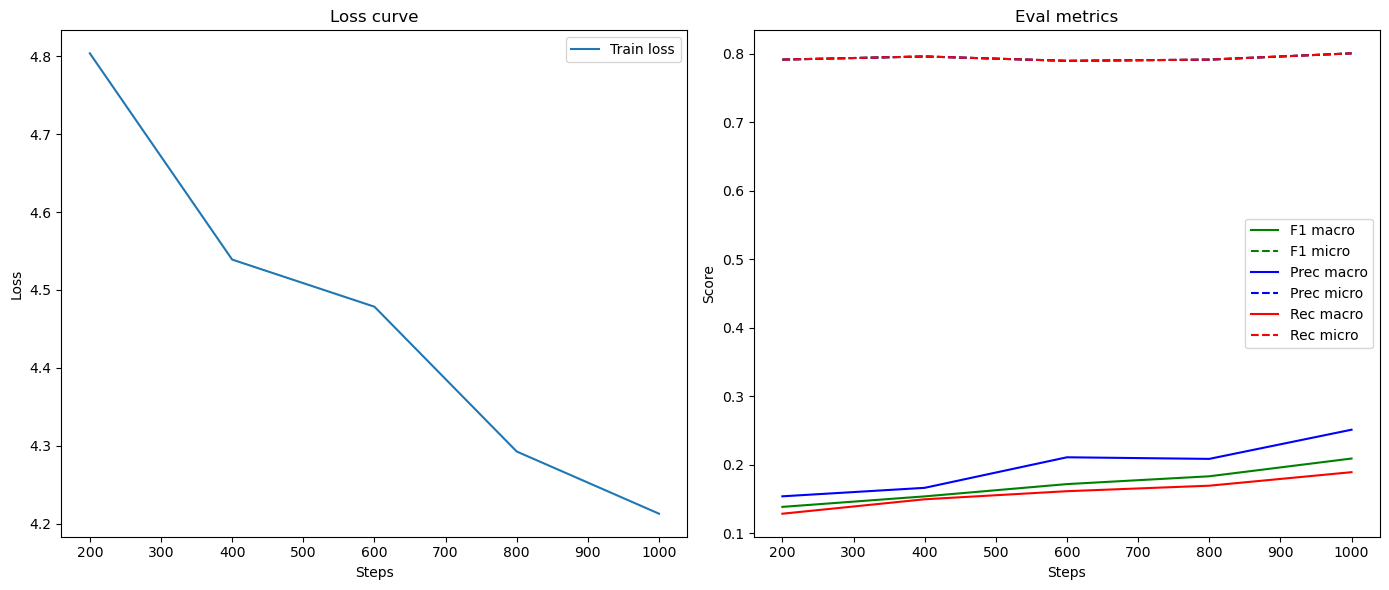

In [40]:
plot_eval()